In [144]:
#Documentation : http://docs.scipy.org/doc/scipy/reference/sparse.html
"""
Sparse matrices can be used in arithmetic operations: they support addition, subtraction, multiplication, division, and matrix power.
Advantages of the CSR format

        efficient arithmetic operations CSR + CSR, CSR * CSR, etc.
        efficient row slicing
        fast matrix vector products
Disadvantages of the CSR format

        slow column slicing operations (consider CSC)
        changes to the sparsity structure are expensive (consider LIL or DOK)
"""
from scipy.sparse import csr_matrix
from scipy.sparse import dia_matrix
import scipy.sparse.linalg as spl

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# SpectralGraphTheory

## Introduction
This notebook intends to show some experimental work about spectral graph theory, and in this case mainly about spectral clustering
We will try to reproduce some of the interesting principle presented in the paper by Andrew Ng (On spectral clustering: Analysis and an algorithm.)

## Graph as matrices
In this notebook we will only be using undirected graphs, whose structure can be represented using an adjacency matrix $A \in \mathbb{R}^{n\times n}$ that can be designed as follow for, $n$ vertices $s_i, i = 0,1,\dots n-1$:
$$
    A_{ij} =
    \begin{cases}
        e^{-\frac{\|s_i-s_j\|}{2\sigma^2}},& \text{if } i\neq j\\
        0              & \text{otherwise}
    \end{cases}
$$

For any vertex $s_i$ we define its degree $d_j$ as the sum of the $j^{th}$ row of the matrix $A$.
From this we can also define $D = diag(d_0, d_1,\dots,d_{n-1})$ 

## Laplacian and normalized laplacian

We can define the Laplacian operator , which in our case is also known as "normalized laplacian" L:
$$
    L = D^{-\frac{1}{2}}AD^{-\frac{1}{2}}
$$

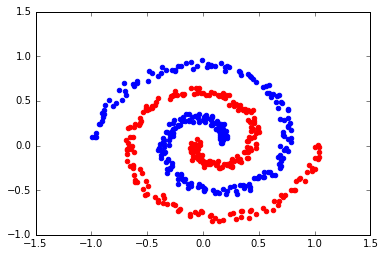

In [145]:
#Let's first define some funny manifold in R2
N = 256
#norm = np.log(np.linspace(np.exp(0.1),np.exp(1),N))
norm = np.linspace(0.1,1,N)
angle = 2*np.pi*np.linspace(0,1,N)*1.5 #we want a loop of 1.5 times the circle
angle2 = 1*np.pi+2*np.pi*np.linspace(0,1,N)*1.5 #we want a loop of 1.5 times the circle

#defines 2 sets of points, that we will try to cluster later, and add noise
NbOfClass = 2
noise = np.random.rand(2,N)*0.1
points=norm*[np.cos(angle),np.sin(angle)]+noise
noise = np.random.rand(2,N)*0.1
points2=norm*[np.cos(angle2),np.sin(angle2)]+noise

#Simple example for isotropic gaussian distribution
#sigmaNoise = 0.3
#points = np.array([np.random.normal(-1,sigmaNoise,N),np.random.normal(-1,sigmaNoise,N)])
#points2 = np.array([np.random.normal(1,sigmaNoise,N),np.random.normal(1,sigmaNoise,N)])

#Point cloud
plt.scatter(points[0,:],points[1,:], color='b')
plt.scatter(points2[0,:],points2[1,:], color='r')

In [146]:
#Now we will concatenate those points
points = np.concatenate( (points, points2), axis=1 )

In [147]:
#Threshold: Below this value we consider that vertices are not connected
thresh= 1e-4
#Sigma of the gaussian distance metric
sigma = 5e-2
sigmaSquare = sigma**2
#will contain the value of the edges
data=[]
rowIdx=[]
colIdx=[]

#Now we are going to fill the graph matrix, neglecting small terms
for idxI in range(points.shape[1]):
    for idxJ in range(idxI+1,points.shape[1]):
        dist = np.exp(-np.linalg.norm(points[:,idxI]-points[:,idxJ])**2/(2*sigmaSquare))
        if( dist > thresh ):
            data.append(dist)
            data.append(dist)
            rowIdx.append(idxI)
            rowIdx.append(idxJ)
            colIdx.append(idxJ)
            colIdx.append(idxI)

#Practical implementation using scipy support for sparse matrices
A = csr_matrix((np.array(data), (np.array(rowIdx), np.array(colIdx))), dtype=np.float32)

#Now the diagonal matrix
D = dia_matrix((np.array(A.sum(axis=0)),0),shape=A.shape)

#We can define the laplacian: L = D^-0.5 A D^-0.5
L = D.power(-0.5)*A*D.power(-0.5)

## Clustering algorithm initialization
We will now implement the spectral clustering algorithm from Andrew Ng and Michael Jordan, which reads as follows:


In [148]:
#Spectral Dimensionality reduction that will be used, must be equal to nb of class
SpectralDimensionality = NbOfClass

# Get the two first eigenvalues of L, a symmetric positive definite matrix
# See http://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html and
# http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.svds.html
[w,X] = spl.eigsh(L, k=2)

#with w : array Array of k eigenvalues
#with X : array An array representing the k eigenvectors.
#The column X[:, i] is the eigenvector corresponding to the eigenvalue w[i].

#As stated in Andrew Ng paper, we will now perform row normalization of these eigen values
Y=np.divide(X.T,np.linalg.norm(X,axis=1)).T


## Run K-Means unsupervised clustering on spectral data

In [149]:
NbIterKMean = 250
iterIdx = 0

#Initialize centroids
centroids = Y[np.random.randint(points.shape[1],size=NbOfClass),:]
#Initialize the previous minimal distance map, with cluster 0
distmap = np.linalg.norm(Y-centroids[0,:],axis=1)
#Initialize "belonging vector" that contains for each sample its class
belong = np.zeros([points.shape[1]],dtype=np.int)
#Do we need to change cluster ?
changeCluster = np.zeros([points.shape[1]],dtype=np.bool)
changeCluster.fill(True)

while( changeCluster.any() and iterIdx < NbIterKMean):
    #Assign points to clusters
    for clusterIndex in range(NbOfClass):
        #Compute the current distance between every point and the current centroid
        distance = np.linalg.norm(Y-centroids[clusterIndex,:],axis=1)
        #Does we need to change cluster (boolean vector)
        changeCluster = distance < distmap
        #if so update belonging matrix, and distmap
        belong[changeCluster] = clusterIndex
        distmap = np.minimum(distance, distmap)

    #update centroids
    for clusterIndex in range(NbOfClass):
        centroids[clusterIndex,:] = np.mean(Y[belong==clusterIndex,:])
        
    iterIdx += 1

## Evaluate classification results

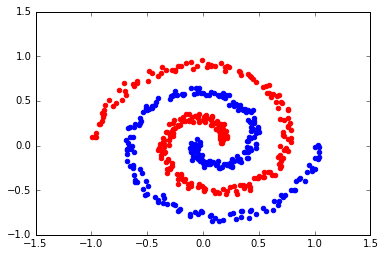

In [150]:
#Assign the resulting classification to vectors
part1 = points[:,belong==0]
part2 = points[:,belong==1]

#Point cloud
plt.scatter(part1[0,:],part1[1,:], color='b')
plt.scatter(part2[0,:],part2[1,:], color='r')

## References

Book :
Lectures on Spectral Graph Theory by FanR.K.Chung: http://www.math.ucsd.edu/~fan/cbms.pdf

Article:
Ng, A. Y., Jordan, M. I., & Weiss, Y. (2002). On spectral clustering: Analysis and an algorithm. Advances in neural information processing systems, 2, 849-856.
http://ai.stanford.edu/~ang/papers/nips01-spectral.pdf